In [1]:
#Importing frequently used libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [3]:
# Importing the training dataset and viewing it
df_train = pd.read_csv("https://raw.githubusercontent.com/anshuman1823/titanic/master/Data/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Pre-Processing Data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The following insights can be made from the above:
* NaN values in Age column will need to be treated.
* NaN values in Cabin mean No Cabin allotted.

Before going on to pre-process the data, we will do basic Feature Engineering to create new features to better capture the trends of the data. We will:
1. Create a function to extract Title from the Name column and discard the Name column.
2. Extract Deck information from the Cabin column (first alphabet indicated Deck) and store it in a separate column called "Deck".
3. Create a column "FamilySize" which equals the sum of Parch and SibSp columns.
4. Create a column "FarePerPerson" which equals total fare divided by FamilySize + 1.
5. Create a function to extract Ticket Prefix and store it in a separate column "TicketPrefix".
6. Create a column with no. of cabins (if Cabin allotted).

In [5]:
# Creating a dummy database to check the working of the custom functions
df_tmp = df_train.copy()
df_tmp.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will classify the following titles for males ["Mr.", "Master", "Col.", "Major", "Rev.", "Dr."] and the following for females ["Miss.", "Ms.", "Mrs.", "Dr."]. People with any other title will be given Mr./Miss. according to their Sex.

In [6]:
# Creating a sub function for classifying titles
def return_title(df):
    x = df.Title
    if x in ["Mr.", "Master", "Col.", "Major", "Rev."]:
        return x
    elif x in ["Miss.", "Ms."]:
        return "Miss."
    elif x in ["Mrs."]:
        return "Mrs."
    elif x in ["Dr."]:
        return "Dr."
    elif df['Sex'] is "male":
        return "Mr."
    else:
        return "Miss."

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-c1ec234e31d7>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif df['Sex'] is "male":


In [7]:
# Creating a function to extract Title information from the Name column and store it in "Title" column
# using return_title function. Then finally discarding the Name Columns.
def Title_extract(df):
    df["Title"] = df.Name.str.split(" ").str[1]
    df["Title"] = df.apply(return_title, axis = 1)
    df = df.drop(["Name"], axis = 1)
    return df

In [8]:
# Checking the working of the above function
df_tmp = Title_extract(df_tmp)
df_tmp.Title.value_counts(), df_tmp.head()

(Mr.      502
 Miss.    253
 Mrs.     121
 Dr.        7
 Rev.       6
 Col.       2
 Name: Title, dtype: int64,
    PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
 0            1         0       3    male  22.0      1      0   
 1            2         1       1  female  38.0      1      0   
 2            3         1       3  female  26.0      0      0   
 3            4         1       1  female  35.0      1      0   
 4            5         0       3    male  35.0      0      0   
 
              Ticket     Fare Cabin Embarked  Title  
 0         A/5 21171   7.2500   NaN        S    Mr.  
 1          PC 17599  71.2833   C85        C   Mrs.  
 2  STON/O2. 3101282   7.9250   NaN        S  Miss.  
 3            113803  53.1000  C123        S   Mrs.  
 4            373450   8.0500   NaN        S    Mr.  )

In [9]:
# Creating a column to extract the deck info (first alphabet from the cabin column) and
# store it in a separate "Deck" column
def Deck(df):
    df["Deck"] = df.Cabin.apply(lambda x: np.nan if pd.isna(x) else x[0])
    return df

In [10]:
# Checking the working of Deck function
df_tmp = Deck(df_tmp)
df_tmp.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,NaN
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,NaN
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.,NaN


In [11]:
# Creating a function to create columns "FamilySize" and "FarePerPerson"
def FamilySize_FarePerPerson(df):
    df["FamilySize"] = df.SibSp + df.Parch
    df["FarePerPerson"] = df.apply(lambda x: x.Fare/(x.FamilySize+1) if x.FamilySize else x.Fare, axis = 1)
    return df

In [12]:
# Checking the working of the above function
df_tmp = FamilySize_FarePerPerson(df_tmp)
df_tmp.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,FarePerPerson
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,NaN,1,3.62500
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,1,35.64165
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,NaN,0,7.92500
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,1,26.55000
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.,NaN,0,8.05000


In [13]:
# Viewing the frequently occuring Ticket Prefixes
df_tmp["TicketPrefix"] = df_tmp.Ticket.str.split(" ").apply(lambda x: x[0] if len(x) > 1 else np.nan)
df_tmp.TicketPrefix.value_counts()

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
SOTON/OQ       7
A/5.           7
STON/O2.       6
CA             6
SC/PARIS       5
S.O.C.         5
F.C.C.         5
C              5
SC/Paris       4
PP             3
S.O./P.P.      3
A/4            3
A/4.           3
SC/AH          3
WE/P           2
SOTON/O2       2
S.C./PARIS     2
A.5.           2
P/PP           2
A./5.          2
F.C.           1
Fa             1
S.C./A.4.      1
SCO/W          1
A4.            1
S.O.P.         1
W.E.P.         1
C.A./SOTON     1
S.P.           1
SW/PP          1
SO/C           1
S.W./PP        1
SC             1
A/S            1
W/C            1
Name: TicketPrefix, dtype: int64

In [14]:
# Creating a function to extract frequently the prefixes of Tickets from the Ticket Column
# Sub-function
def ticket_pre(x):
    if x is "NaN":
        return np.nan
    elif np.any(np.isin(x, ["PC"])):
        return "PC"
    elif np.any(np.isin(x, ["C.A.", "CA", "CA.", "C" ])):
        return "CA"
    elif np.any(np.isin(x.split("/"), ["STON", "SOTON"])):
        return "SOTON"
    elif np.any(np.isin(x, ["A/5", "A.5.", "A/5."])):
        return "A/5"
    elif np.any(np.isin(x, ["A/4.", "A.4.", "A4.", "A/4"])):
        return "A/4"
    elif np.any(np.isin(x, ["W./C."])):
        return "W./C."
    else:
        return "Other"
def TicketPrefix(df):
    df["TicketPrefix"] = df.Ticket.str.split(" ").apply(lambda x: ticket_pre(x[0]) if len(x)>1 else np.nan)
    return df

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-14-23065bf3a4b9>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is "NaN":


In [15]:
# Checking the working of the above function
df_tmp = TicketPrefix(df_tmp)
df_tmp.TicketPrefix.value_counts(), df_tmp.head()

(PC       60
 Other    49
 CA       46
 SOTON    36
 A/5      19
 W./C.     9
 A/4       7
 Name: TicketPrefix, dtype: int64,
    PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
 0            1         0       3    male  22.0      1      0   
 1            2         1       1  female  38.0      1      0   
 2            3         1       3  female  26.0      0      0   
 3            4         1       1  female  35.0      1      0   
 4            5         0       3    male  35.0      0      0   
 
              Ticket     Fare Cabin Embarked  Title Deck  FamilySize  \
 0         A/5 21171   7.2500   NaN        S    Mr.  NaN           1   
 1          PC 17599  71.2833   C85        C   Mrs.    C           1   
 2  STON/O2. 3101282   7.9250   NaN        S  Miss.  NaN           0   
 3            113803  53.1000  C123        S   Mrs.    C           1   
 4            373450   8.0500   NaN        S    Mr.  NaN           0   
 
    FarePerPerson TicketPrefix  
 0        3.625

In [16]:
# Creating a function to add Cabin_count column
def Cabin_count(df):
  df["Cabin_count"] = df.apply(lambda x: len(x.Cabin.split(" ")) if not pd.isna(x.Cabin) else np.nan, axis = 1)
  return df

In [17]:
# Checking the above function to view the variation in the number of Cabins
df_tmp = Cabin_count(df_tmp)
df_tmp.Cabin_count.value_counts()

1.0    180
2.0     16
3.0      6
4.0      2
Name: Cabin_count, dtype: int64

Now that we have done Basic Feature Engineering, let's do some basic EDA

# EDA

In [18]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Sex            891 non-null    object 
 4   Age            714 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Ticket         891 non-null    object 
 8   Fare           891 non-null    float64
 9   Cabin          204 non-null    object 
 10  Embarked       889 non-null    object 
 11  Title          891 non-null    object 
 12  Deck           204 non-null    object 
 13  FamilySize     891 non-null    int64  
 14  FarePerPerson  891 non-null    float64
 15  TicketPrefix   226 non-null    object 
 16  Cabin_count    204 non-null    float64
dtypes: float64(4), int64(6), object(7)
memory usage: 118.5

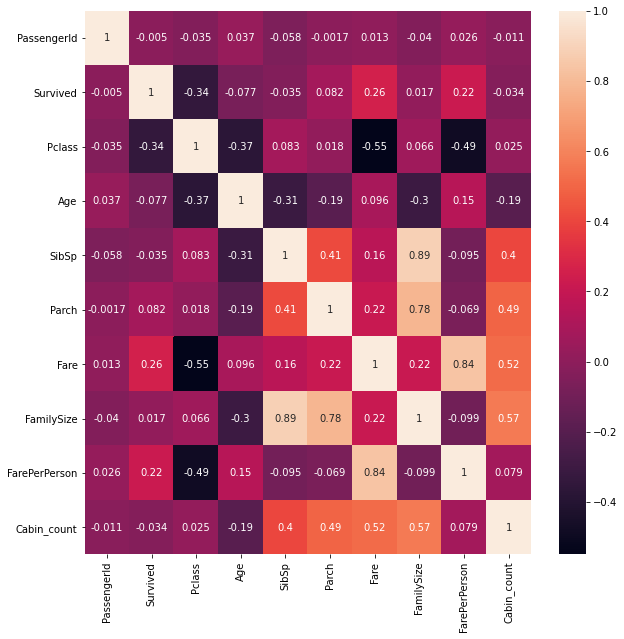

In [19]:
# Plotting correlation matrix for the numerical columns
plt.figure(figsize = (10, 10))
sns.heatmap(df_tmp.corr(), annot = True);

* We can see that Fare and FarePerPerson are highly correlated, which was somewhat expected. 
* PClass is highly correlated with Fare and FarePerPerson.
* PClass, Fare and FarePerPerson are all somewhat highly correlated with Survived (target column)

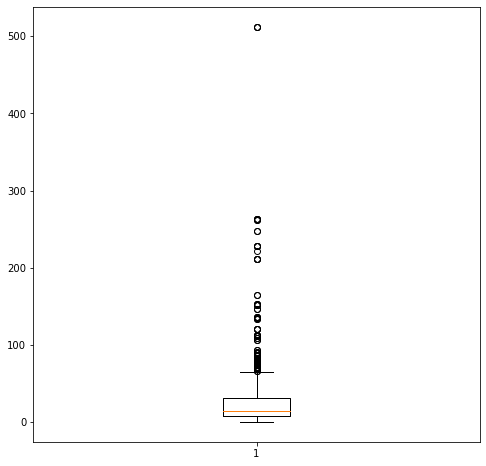

In [20]:
# Fare column boxplot
plt.figure(figsize = (8, 8))
plt.boxplot(df_tmp.Fare);

We can see that Fare has a lot of outliers...Entries with Fare > 300:

In [21]:
df_tmp[df_tmp.Fare > 300]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,FarePerPerson,TicketPrefix,Cabin_count
258,259,1,1,female,35.0,0,0,PC 17755,512.3292,NaN,C,Miss.,NaN,0,512.3292,PC,NaN
679,680,1,1,male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr.,B,1,256.1646,PC,3.0
737,738,1,1,male,35.0,0,0,PC 17755,512.3292,B101,C,Mr.,B,0,512.3292,PC,1.0


**Let's make a note to remove these outliers when the data is processed further later on.** 

Furthermore, there are some values with zero value. Let's see their count:

In [22]:
df_tmp[df_tmp.Fare == 0]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,FarePerPerson,TicketPrefix,Cabin_count
179,180,0,3,male,36.0,0,0,LINE,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
263,264,0,1,male,40.0,0,0,112059,0.0,B94,S,Mr.,B,0,0.0,NaN,1.0
271,272,1,3,male,25.0,0,0,LINE,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
277,278,0,2,male,NaN,0,0,239853,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
302,303,0,3,male,19.0,0,0,LINE,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
413,414,0,2,male,NaN,0,0,239853,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
466,467,0,2,male,NaN,0,0,239853,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
481,482,0,2,male,NaN,0,0,239854,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
597,598,0,3,male,49.0,0,0,LINE,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN
633,634,0,1,male,NaN,0,0,112052,0.0,NaN,S,Mr.,NaN,0,0.0,NaN,NaN


**These are 15 in number. Let's make a note to remove these entries later on!!**

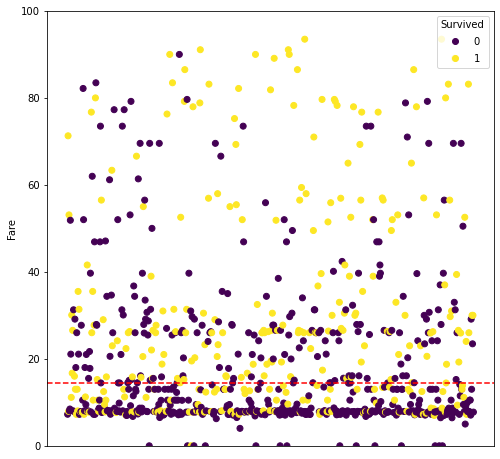

In [23]:
# Visualizing the relation between Fare and Survived
plt.figure(figsize = (8, 8))
scatter1 = plt.scatter(np.arange(len(df_tmp.Fare)), df_tmp.Fare, c = df_tmp.Survived)
plt.ylim((0, 100)) # Because most of the data lies in this range
plt.ylabel("Fare")
plt.xticks([])
plt.axhline(df_tmp.Fare.median(), linestyle = "--", color = 'red') #Fare Line Median
plt.legend(*scatter1.legend_elements(), title = "Survived", loc = "upper right");

We can see that higher Fares have more number of people who survived, thus suggesting decent correlation between Fares and Survived Class. 

Let's further visualize this fact using a bargraph:

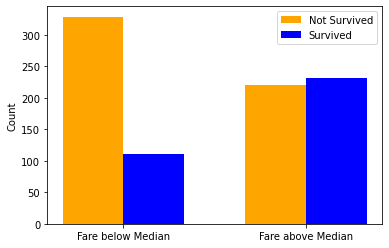

In [24]:
high_fare = df_tmp[df_tmp.Fare >= df_tmp.Fare.median()]
low_fare = df_tmp[df_tmp.Fare < df_tmp.Fare.median()]
plt.bar([0.4, 2.8], [low_fare[low_fare.Survived == 0].Survived.count(), high_fare[high_fare.Survived == 0].Survived.count()], color = "orange", label = "Not Survived")
plt.bar([1.2, 3.6], [low_fare[low_fare.Survived == 1].Survived.count(), high_fare[high_fare.Survived == 1].Survived.count()], color = "blue", label = "Survived")
plt.xticks(ticks = [0.8, 3.2], labels = ["Fare below Median", "Fare above Median"])
plt.ylabel("Count")
plt.legend()
plt.show();

The above graph shows that when Fare is below Median, almost 3 out of every 4 people did not survive. But when the fare is above Medain, the chances of survival are aprrox. 50%.

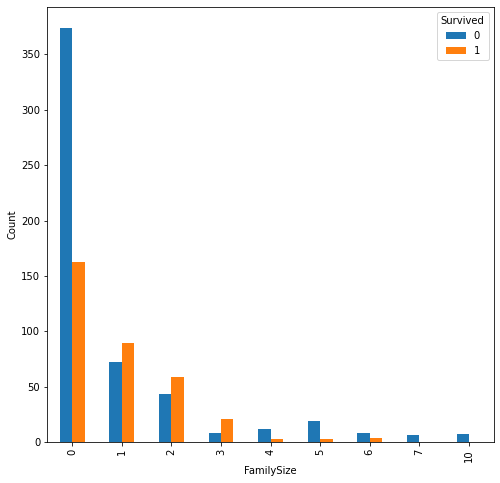

In [25]:
# Let's analyze the relation between FamilySize and Survived
df_cross = pd.crosstab(index = df_tmp.FamilySize, columns = df_tmp.Survived)
df_cross.plot.bar(figsize = (8,8))
plt.ylabel("Count");

There isn't a very clear trend visible (other than the fact that a large no. of solo travellers were there).

Let's analyze any relation between the Age column and the Survived columns:

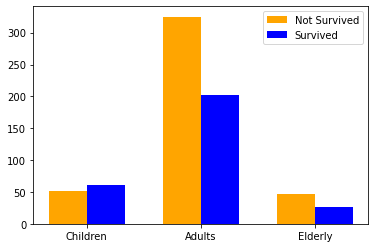

In [26]:
# Let's Divide People in ["Children (Age<18)", "Adults (18 < Age < 50)", "Elderly (Age > 50)"]
children = df_tmp[df_tmp.Age < 18]
adults = df_tmp[(df_tmp.Age >= 18) & (df_tmp.Age < 50)]
elderly = df_tmp[df_tmp.Age >= 50]
# Plotting a Bar Graph Using the above data
plt.bar([0.4, 2.8, 5.2], [children[children.Survived == 0].Survived.count(), adults[adults.Survived == 0].Survived.count(), elderly[elderly.Survived == 0].Survived.count()],
        color = 'orange', label = "Not Survived")
plt.bar([1.2, 3.6, 6], [children[children.Survived == 1].Survived.count(), adults[adults.Survived == 1].Survived.count(), elderly[elderly.Survived == 1].Survived.count()],
        color = 'blue', label = "Survived")
plt.xticks(ticks = [0.8, 3.2, 5.6], labels = ["Children", "Adults", "Elderly"])
plt.legend()
plt.show();

Here, the proportion of people who survived is the highest in children and lowest in elderly. This may indicate some preferrential treatment that might have been given to the children and the elderly to ensure their survival.

Let's see the variation in Survived column vs Sex column:

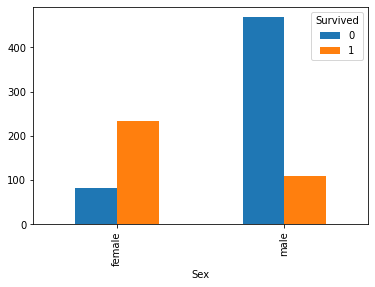

In [27]:
sex_cross = pd.crosstab(index = df_tmp.Sex, columns= df_tmp.Survived)
sex_cross.plot.bar();

This shows that Female survival ratio is much higher than men. Therefore, Sex is highly correlated with Survived.

# Making the data ready for modeling

We will need to peform the following tasks before we can use the data in our ML model:
1. Remove the entries which have invalid/in-sufficient data.
2. Split the dataset into train and test dataset.
3. Impute NaN values in the numeric columns with median, and create another column which will specify which rows had the NaN values before imputation
4. Convert all object dtype columns into categorical columns, and create a separate column specifying the entries where NaN values were present. Therefore, after all these operations, all columns will have numerical dtype.

In [28]:
# Creating a function to remove entries with (1) Fare == 0, (2) Fare > 300
def clean_Fare(df):
  df = df[(df.Fare > 0) & (df.Fare <= 300)]
  return df

In [29]:
# Checking the working of the above function
df_tmp = clean_Fare(df_tmp)
df_tmp.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,FarePerPerson,Cabin_count
count,873.000000,873.000000,873.000000,704.000000,873.000000,873.000000,873.000000,873.000000,873.000000,199.000000
mean,444.402062,0.387171,2.319588,29.620980,0.533792,0.388316,31.107631,0.922108,18.859871,1.160804
std,257.858537,0.487382,0.833526,14.585118,1.111477,0.812291,41.331513,1.625028,26.135055,0.496728
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500,0.000000,1.132143,1.000000
25%,220.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.925000,0.000000,7.520800,1.000000
50%,444.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000,0.000000,8.662500,1.000000
75%,666.000000,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000,1.000000,24.150000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000,10.000000,227.525000,4.000000


In [32]:
# Creating a function to split the data into train and test dataset (by default test = 0.2 * train)
def train_test(df, test_size = 0.2):
  """
  Returns X_train, X_test, y_train, y_test
  """
  from sklearn.model_selection import train_test_split
  X = df.drop(["Survived"], axis = 1)
  y = df.Survived
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
  print(f"SHAPES >>> X_train: {X_train.shape}, X_val: {X_test.shape}, y_train: {y_train.shape}, y_val: {y_test.shape}")
  return X_train, X_test, y_train, y_test

In [33]:
# Checking the working of the above function
X_train, X_test, y_train, y_test = train_test(df_tmp, 0.2)

SHAPES >>> X_train: (698, 16), X_val: (175, 16), y_train: (698,), y_val: (175,)


In [34]:
# Creating function to (1) Impute Numerical Columns with NaN values with median 
# (2) Create separate columns (for columns with NaN values) indicating the rows where NaN values are present
# (3) Convert object dtype columns to categorical columns
# (4) Convert Categorical dtype Columns into Numerical Columns

def convert_to_numeric(df):
  to_categorical = []
  for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
      if df[label].isna().sum():
        print(f"{label} column is of numeric dtype and contains NaN values. Creating '{label}_is_missing' and imputing NaN values with median")
        df[label + "_is_missing"] = df[label].isna()
        df[label].fillna(df[label].median(), inplace = True)
      else:
        pass
    elif pd.api.types.is_string_dtype(content):
      if df[label].isna().sum():
        print(f"{label} column is of object dtype and contains NaN values. Creating '{label}_is_missing' column")
        df[label + "_is_missing"] = df[label].isna()
        df[label] = df[label].astype("category").cat.as_ordered()
        df[label] = pd.Categorical(df[label]).codes + 1
        to_categorical.append(label)
      else:
        df[label] = df[label].astype("category").cat.as_ordered()
        df[label] = pd.Categorical(df[label]).codes + 1
        to_categorical.append(label)
    else:
      pass
  print(f"The following columns have been converted from object to numeric dtype: {to_categorical}")
  return df

In [35]:
# Checking the working of the above function
X_train = convert_to_numeric(X_train)
X_train.info()

Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Embarked column is of object dtype and contains NaN values. Creating 'Embarked_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 125 to 585
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0 

The above function works as intended!!!
Using the above function on X_test as well:

In [36]:
X_test = convert_to_numeric(X_test)

Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']


In [37]:
# Viewing X_train
X_train.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,FamilySize,FarePerPerson,TicketPrefix,Cabin_count,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Deck_is_missing,TicketPrefix_is_missing,Cabin_count_is_missing
125,126,3,2,12.0,1,0,149,11.2417,0,1,...,1,5.62085,0,1.0,False,True,False,True,True,True
887,888,1,1,19.0,0,0,11,30.0000,22,3,...,0,30.00000,0,1.0,False,False,False,False,True,False
628,629,3,2,26.0,0,0,294,7.8958,0,3,...,0,7.89580,0,1.0,False,True,False,True,True,True
282,283,3,2,16.0,0,0,248,9.5000,0,3,...,0,9.50000,0,1.0,False,True,False,True,True,True
794,795,3,2,25.0,0,0,280,7.8958,0,3,...,0,7.89580,0,1.0,False,True,False,True,True,True
114,115,3,1,17.0,0,0,141,14.4583,0,1,...,0,14.45830,0,1.0,False,True,False,True,True,True
348,349,3,2,3.0,1,1,460,15.9000,0,3,...,2,5.30000,3,1.0,False,True,False,True,False,True
726,727,2,1,30.0,3,0,206,21.0000,0,3,...,3,5.25000,0,1.0,False,True,False,True,True,True
456,457,1,2,65.0,0,0,61,26.5500,101,3,...,0,26.55000,0,1.0,False,False,False,False,True,False
868,869,3,2,28.0,0,0,247,9.5000,0,3,...,0,9.50000,0,1.0,True,True,False,True,True,True


In [38]:
# Let's combine all the above functions into a single function to process the training data
def process_master(df, test_size = 0.2, test_database = False):
  """
  This function takes a training/testing database, fully processes it and
  reutrns a train + valid database (X_train, X_val, y_train, y_val) if training 
  database is input, otherwise returns test database if test database is input.

  Check the columns of the train/test database for ensuring consistent number of columns!!
  """
  if not test_database:
    print("Creating training and validation databases...")
    df = Title_extract(df)
    df = Deck(df)
    df = FamilySize_FarePerPerson(df)
    df = TicketPrefix(df)
    df = Cabin_count(df)
    df = clean_Fare(df)
    X_train, X_val, y_train, y_val = train_test(df, test_size = test_size)
    X_train = convert_to_numeric(X_train)
    X_val = convert_to_numeric(X_val)
    print(f"Final SHAPES >>> X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")
    return X_train, X_val, y_train, y_val
  else:
    print("Creating test database...")
    df = Title_extract(df)
    df = Deck(df)
    df = FamilySize_FarePerPerson(df)
    df = TicketPrefix(df)
    df = Cabin_count(df)
    df = convert_to_numeric(df)
    print(f"Final SHAPE >>> X_test: {df.shape}")
    return df

In [39]:
#Checking the working of the above function for training database case
X_train, X_val, y_train, y_val = process_master(df_train)

Creating training and validation databases...
SHAPES >>> X_train: (698, 16), X_val: (175, 16), y_train: (698,), y_val: (175,)
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Embarked column is of object dtype and contains NaN values. Creating 'Embarked_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputi

In [40]:
# Checking the working of the above function for test database case
df_test = process_master(df_train.drop(["Survived"], axis = 1), test_database=True)
df_test.shape

Creating test database...
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Embarked column is of object dtype and contains NaN values. Creating 'Embarked_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
Final SHAPE >>> X_test: (891, 22)


(891, 22)

So far, the function is working perfectly !!! 

# Feature Selection

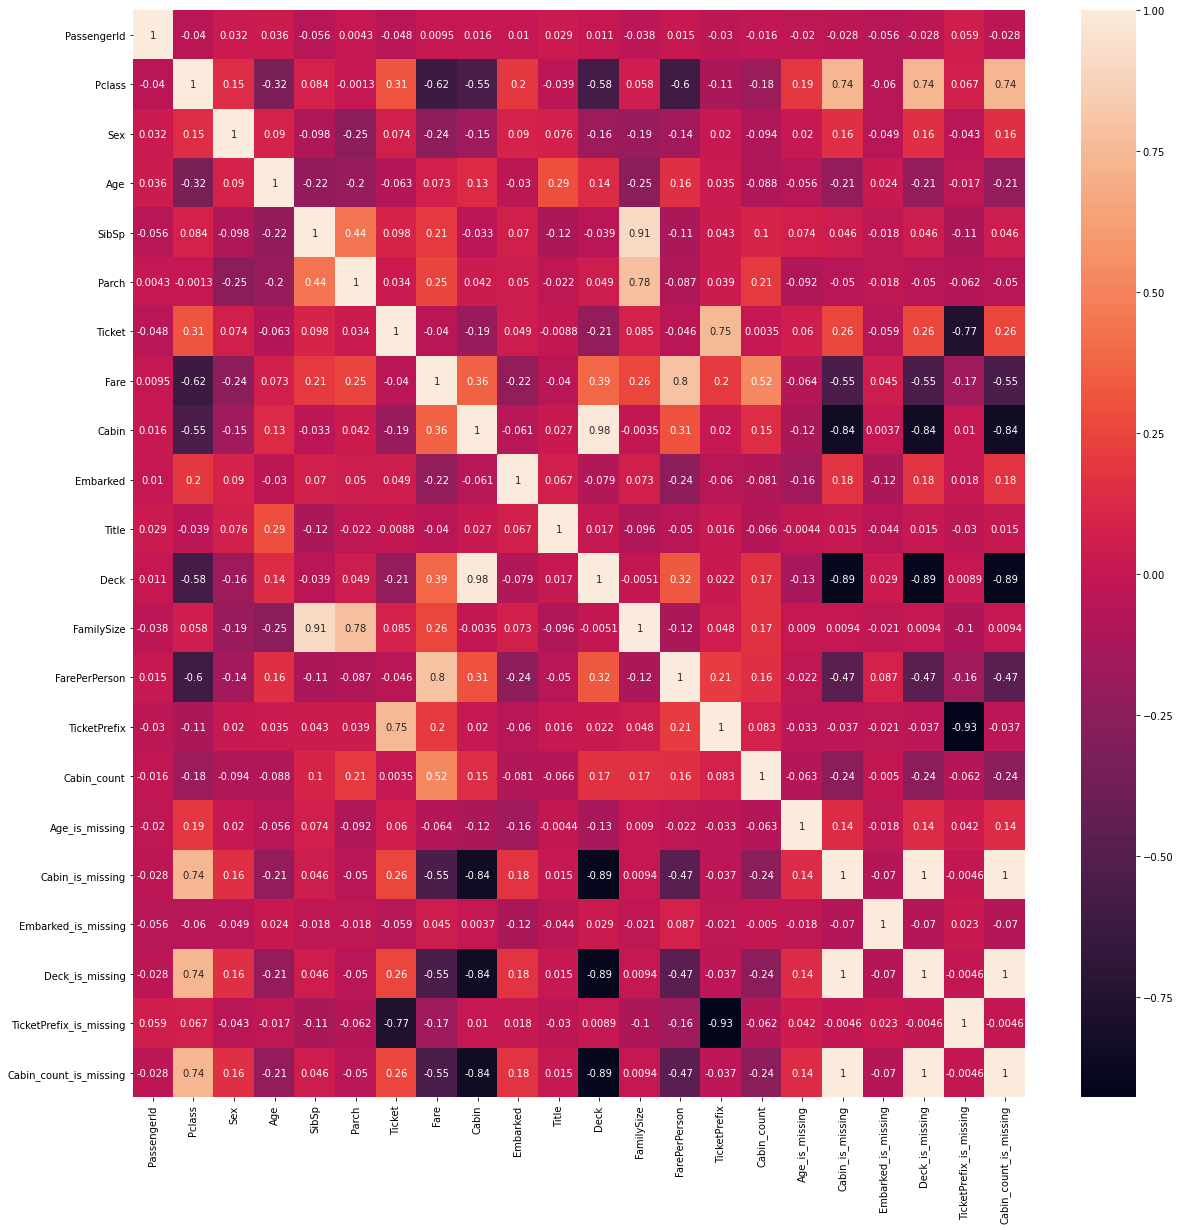

In [41]:
# Let's check the correlation of the features
plt.figure(figsize = (20,20))
sns.heatmap(X_train.corr(),annot = True)

We can see that there are a lot of features that are highly correlated with each other, (especially the missing columns related to cabin, deck and cabin_count and Fare). 

We should remove highly correlated features before using the data to build our model.

We should also remove redundant columns, like the Ticket column, which don't provide any additional information.

In [42]:
# Removing ["PassengerId", "Ticket", "FamilySize", "FarePerPerson", "Cabin_is_missing", "Deck_is_missing", "TicketPrefix_is_missing", "Cabin_count_is_missing"] columns
X_train = X_train.drop(labels = ["PassengerId", "Ticket", "FamilySize", "FarePerPerson", "Cabin_is_missing", "Deck_is_missing", "TicketPrefix_is_missing", "Cabin_count_is_missing"],
                       axis = 1)
X_val = X_val.drop(labels = ["PassengerId", "Ticket", "FamilySize", "FarePerPerson", "Cabin_is_missing", "Deck_is_missing", "TicketPrefix_is_missing", "Cabin_count_is_missing"],
                       axis = 1)

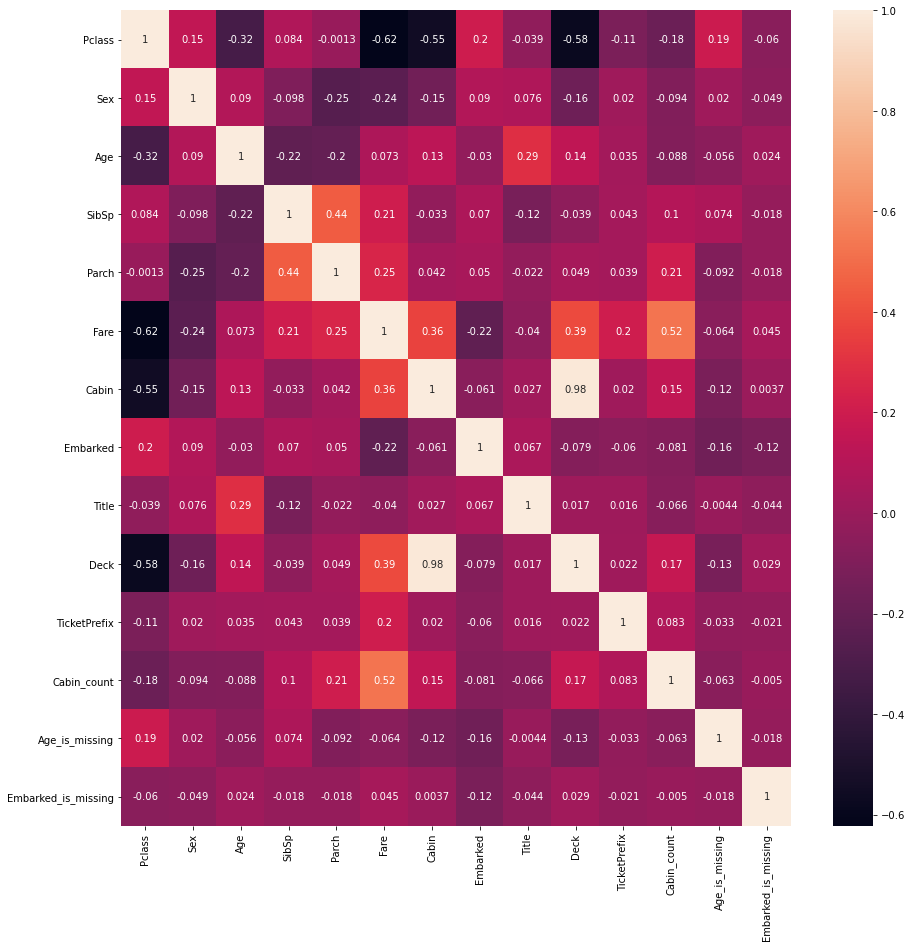

In [43]:
#Let's see the correlation matrix once again
plt.figure(figsize = (15,15))
sns.heatmap(X_train.corr(), annot = True)

# Building a Machine Learning Model

Now that wee have our data ready, let's select a machine learning algorithm for our model.

Let's see the performance of Random Forest Classifier, Logistic Regression, K Neighbors Classifier and SVM and Linear SVM. Then we'll select one which performs the best.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
scores = {}
models = {"RandomForestClassifier": RandomForestClassifier(),
         "LogisticRegression": LogisticRegression(max_iter = 10000),
         "KNN": KNeighborsClassifier(),
         "SVC": svm.SVC(),
         "LinearSVC": svm.LinearSVC(max_iter = 100000)}
for name, model in models.items():
    model.fit(X_train, y_train)
    scores[name] = model.score(X_val, y_val)
scores

We can see that Random Forest Classifier has performed the best. So, Let's first try building a model using Random Forest!

## Random Forest Classifier

### Feature Importance

Let's see the Feature  Importance for the Random Forest Classifier Model

In [171]:
# Creating a function for plotting Feature Importance
def plot_feat_imp(columns, importance):
    """
    Plot the feature importance for an ensemble estimator
    """
    df = pd.DataFrame(data = {"Feature_importance": importance}, index = columns)
    df.sort_values("Feature_importance", inplace = True)
    df.plot.barh()
#     plt.xticks(rotation = 'verticle')

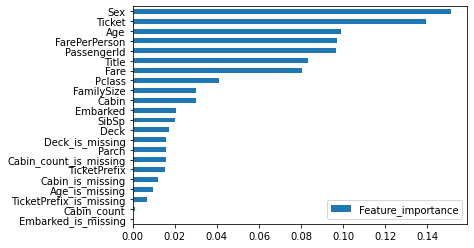

In [172]:
# Checking Feature  Importance
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
plot_feat_imp(X_train.columns, rfc.feature_importances_)

Therefore, the most important features are Sex, Age and Fare. That looks promising...

### Hyper-parameter Tuning

#### Randomized Search

Let's use Randomized Search for finding a suitable range of hyper parameters which we can fine tune later using Grid Search. 

In [ ]:
# Building a grid of parameters for Randomized Search
rfc_randgrid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Running Randomized Search
from sklearn.model_selection import  RandomizedSearchCV
rfc_rand = RandomizedSearchCV(RandomForestClassifier(), param_distributions = rfc_randgrid, n_iter = 100, n_jobs = -1, cv = 3, verbose = 1, random_state = 23)
rfc_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# Scoring the best model from Randomized Search on Validation set
rfc_rand.score(X_val, y_val)

0.7885714285714286

In [ ]:
# Obtaining the best set of parameters from Randomized Search for fine tuning using Grid Search
rfc_rand.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

#### Grid Search

In [ ]:
# # Building a grid of parameters for Randomized Search
# rfc_randgrid = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Grid of hyper parameters for Grid Search
rfc_grid = {'bootstrap': [False],
 'max_depth': [5, 10, 15, 20],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [8, 10, 12],
 'n_estimators': [900, 1000, 1100, 1200]}

In [ ]:
# Running Grid Search
from sklearn.model_selection import GridSearchCV
rfc_gridsearch = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rfc_grid, cv = 3, n_jobs = -1, verbose = 1)
rfc_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  5.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# The score of the best set of hyperparameters on the validation model
rfc_gridsearch.score(X_val, y_val)

0.7885714285714286

In [ ]:
# Obtaining the best set of hyperparameters from Grid Search
rfc_gridsearch.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

Now, lets use the above hyperparameters and fit the Random Forest Classifier on the whole training dataset

In [ ]:
# Combining the train and validation datasets
X_train_combined = pd.concat([X_train, X_val], axis = 0)
y_train_combined = pd.concat([y_train, y_test], axis = 0)
X_train_combined.shape, y_train_combined.shape

((873, 14), (873,))

In [173]:
# Fitting RandomForestClassifier estimator with the best hyperparameters obtained from GridSearchCV
rfc = RandomForestClassifier(bootstrap = False,
                             max_depth = 10,
                             max_features = 'sqrt',
                             min_samples_leaf = 1,
                             min_samples_split = 10,
                             n_estimators = 1000)
rfc.fit(X_train_combined, y_train_combined)
rfc.score(X_train_combined, y_train_combined)

### Preparing the test DataSet

In [ ]:
# Preparing the test dataset for prediction
df_test = pd.read_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/original_files/test.csv")
df_test = process_master(df_test, test_database=True)
df_test_PassengerId = df_test.PassengerId #Saving the PassengerId column for later use
df_test = df_test.drop(labels = ["PassengerId", "Ticket", "FamilySize", "FarePerPerson", "Cabin_is_missing", "Deck_is_missing", "TicketPrefix_is_missing", "Cabin_count_is_missing"],
                       axis = 1)

Creating test database...
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Fare column is of numeric dtype and contains NaN values. Creating 'Fare_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
FarePerPerson column is of numeric dtype and contains NaN values. Creating 'FarePerPerson_is_missing' and imputing NaN values with median
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
Final SHAPE >>> X_test: (418, 23

In [ ]:
# Checking columns consistency between training and test dataset
set(df_test.columns) - set(X_train_combined.columns)

{'FarePerPerson_is_missing', 'Fare_is_missing'}

In [ ]:
# Solving column consistency
df_test = df_test.drop(["FarePerPerson_is_missing", "Fare_is_missing"], axis = 1)
set(df_test.columns) - set(X_train_combined.columns)

set()

In [ ]:
# Checking Reverse Column Consistency
set(X_train_combined.columns) - set(df_test.columns)

{'Embarked_is_missing'}

In [ ]:
#Solving the above  inconsistency
df_test["Embarked_is_missing"] = False
set(X_train_combined.columns) - set(df_test.columns)

set()

In [ ]:
#One final check on the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               418 non-null    int64  
 1   Sex                  418 non-null    int8   
 2   Age                  418 non-null    float64
 3   SibSp                418 non-null    int64  
 4   Parch                418 non-null    int64  
 5   Fare                 418 non-null    float64
 6   Cabin                418 non-null    int8   
 7   Embarked             418 non-null    int8   
 8   Title                418 non-null    int8   
 9   Deck                 418 non-null    int8   
 10  TicketPrefix         418 non-null    int8   
 11  Cabin_count          418 non-null    float64
 12  Age_is_missing       418 non-null    bool   
 13  Embarked_is_missing  418 non-null    bool   
dtypes: bool(2), float64(3), int64(3), int8(6)
memory usage: 23.0 KB


Now, let's make predicitions and create the submission file

### Making Predictions and Creating Submissions File

In [ ]:
# Making prediction from the model
preds = rfc.predict(df_test)

In [ ]:
#Creating the submission file
submission = pd.DataFrame(data = {"PassengerId": df_test_PassengerId, "Survived": preds})
submission.to_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/submission.csv", index = False)

Current Best Accuracy 0.7703 !

## Logistic Regression Classifier

Now, let's try Logistic Regression

### Feature Importance

Let's see the Feature  Importance for the Random Forest Classifier Model

In [ ]:
# Checking the columns of X_train
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked',
       'Title', 'Deck', 'TicketPrefix', 'Cabin_count', 'Age_is_missing',
       'Embarked_is_missing'],
      dtype='object')

In [ ]:
# Function for plotting feature importance:
# def plot_feat_imp(columns, importance):
#     """
#     Plot the feature importance for an ensemble estimator
#     """
#     df = pd.DataFrame(data = {"Feature_importance": importance}, index = columns)
#     df.sort_values("Feature_importance", inplace = True)
#     df.plot.barh()
# #     plt.xticks(rotation = 'verticle')

0.8114285714285714


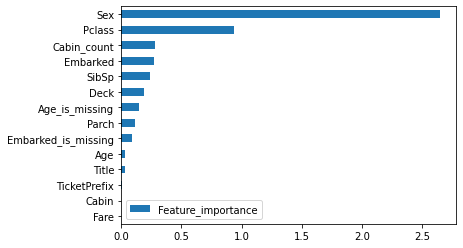

In [ ]:
# Checking Feature  Importance
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
print(log_reg.score(X_val, y_val))
plot_feat_imp(X_train.columns, np.abs(log_reg.coef_[0]))

Here, we can see that Sex, Pclass and cabin count are the most important features.

### Hyper-parameter Tuning

#### Randomized Search

Let's use Randomized Search for finding a suitable range of hyper parameters which we can fine tune later using Grid Search. 

In [ ]:
# Building a grid of parameters for Randomized Search
log_reg_randgrid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'C': list(np.logspace(-4,4,9)),
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'max_iter': [10000]}

In [ ]:
# Running Randomized Search
from sklearn.model_selection import  RandomizedSearchCV
log_reg_rand = RandomizedSearchCV(LogisticRegression(), param_distributions = log_reg_randgrid, n_iter = 100, n_jobs = -1, cv = 3, verbose = 1, random_state = 23)
log_reg_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 297 out of 300 | elapsed:   26.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                              10.0, 100.0, 1000.0, 10000.0],
                                        'max_iter': [10000],
                                        'penalty': ['l1', 'l2', 'el

In [ ]:
# Scoring the best model from Randomized Search on Validation set
log_reg_rand.score(X_val, y_val)

0.7942857142857143

In [ ]:
# Obtaining the best set of parameters from Randomized Search for fine tuning using Grid Search
log_reg_rand.best_params_

{'C': 1.0, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}

#### Grid Search

In [ ]:
# # Building a grid of parameters for Randomized Search
# log_reg_randgrid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#  'C': list(np.logspace(-4,4,9)),
#  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#  'max_iter': [10000]}

In [ ]:
# Grid of hyper parameters for Grid Search
log_reg_grid = {'penalty': ['l1'],
 'C': list(np.logspace(-5,5,9)),
 'solver': ['liblinear'],
 'max_iter': [10000]}

In [ ]:
# Running Grid Search
from sklearn.model_selection import GridSearchCV
log_reg_gridsearch = GridSearchCV(estimator = LogisticRegression(), param_grid = log_reg_grid, cv = 3, n_jobs = -1, verbose = 1)
log_reg_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-05, 0.00017782794100389227,
                               0.0031622776601683794, 0.05623413251903491, 1.0,
                               17.78279410038923, 316.22776601683796,
                               5623.413251903491, 100000.0],
                         'max_iter': [10000], 'penalty': ['l1'],
                

In [ ]:
# The score of the best set of hyperparameters on the validation model
log_reg_gridsearch.score(X_val, y_val)

0.7942857142857143

In [ ]:
# Obtaining the best set of hyperparameters from Grid Search
log_reg_gridsearch.best_params_

{'C': 1.0, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}

Now, lets use the above hyperparameters and fit the Logistic Regression model on the whole training dataset

In [ ]:
# Combining the train and validation datasets
X_train_combined = pd.concat([X_train, X_val], axis = 0)
y_train_combined = pd.concat([y_train, y_test], axis = 0)
X_train_combined.shape, y_train_combined.shape

((873, 14), (873,))

In [174]:
# Fitting RandomForestClassifier estimator with the best hyperparameters obtained from GridSearchCV
log_reg = LogisticRegression(C = 1, max_iter = 10000, penalty = 'l1', solver = 'liblinear')
log_reg.fit(X_train_combined, y_train_combined)
log_reg.score(X_train_combined, y_train_combined)

### Preparing the test DataSet

In [ ]:
# Preparing the test dataset for prediction
df_test = pd.read_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/original_files/test.csv")
df_test = process_master(df_test, test_database=True)
df_test_PassengerId = df_test.PassengerId #Saving the PassengerId column for later use
df_test = df_test.drop(labels = ["PassengerId", "Ticket", "FamilySize", "FarePerPerson", "Cabin_is_missing", "Deck_is_missing", "TicketPrefix_is_missing", "Cabin_count_is_missing"],
                       axis = 1)

Creating test database...
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Fare column is of numeric dtype and contains NaN values. Creating 'Fare_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
FarePerPerson column is of numeric dtype and contains NaN values. Creating 'FarePerPerson_is_missing' and imputing NaN values with median
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
Final SHAPE >>> X_test: (418, 23

In [ ]:
# Checking columns consistency between training and test dataset
set(df_test.columns) - set(X_train_combined.columns)

{'FarePerPerson_is_missing', 'Fare_is_missing'}

In [ ]:
# Solving column consistency
df_test = df_test.drop(["FarePerPerson_is_missing", "Fare_is_missing"], axis = 1)
set(df_test.columns) - set(X_train_combined.columns)

set()

In [ ]:
# Checking Reverse Column Consistency
set(X_train_combined.columns) - set(df_test.columns)

{'Embarked_is_missing'}

In [ ]:
#Solving the above  inconsistency
df_test["Embarked_is_missing"] = False
set(X_train_combined.columns) - set(df_test.columns)

set()

In [ ]:
#One final check on the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               418 non-null    int64  
 1   Sex                  418 non-null    int8   
 2   Age                  418 non-null    float64
 3   SibSp                418 non-null    int64  
 4   Parch                418 non-null    int64  
 5   Fare                 418 non-null    float64
 6   Cabin                418 non-null    int8   
 7   Embarked             418 non-null    int8   
 8   Title                418 non-null    int8   
 9   Deck                 418 non-null    int8   
 10  TicketPrefix         418 non-null    int8   
 11  Cabin_count          418 non-null    float64
 12  Age_is_missing       418 non-null    bool   
 13  Embarked_is_missing  418 non-null    bool   
dtypes: bool(2), float64(3), int64(3), int8(6)
memory usage: 23.0 KB


Now, let's make predicitions and create the submission file

### Making Predictions and Creating Submissions File

In [ ]:
# Making prediction from the model
preds = log_reg.predict(df_test)

In [ ]:
#Creating the submission file
submission = pd.DataFrame(data = {"PassengerId": df_test_PassengerId, "Survived": preds})
submission.to_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/submission_log_reg.csv", index = False)

Current Best Accuracy 0.7799 !

# Experimentation

In [ ]:
X_train_combined = pd.concat([X_train, X_val], ignore_index=True)

In [ ]:
y_train_combined = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
train_combined = X_train_combined.copy()
train_combined["Survived"] = y_train_combined
train_combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,FarePerPerson,TicketPrefix,Cabin_count,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Deck_is_missing,TicketPrefix_is_missing,Cabin_count_is_missing,Survived
0,316,3,1,26.0,0,0,272,7.8542,0,3,3,0,0,7.854200,0,1.0,False,True,False,True,True,True,1
1,722,3,2,17.0,1,0,329,7.0542,0,3,4,0,1,3.527100,0,1.0,False,True,False,True,True,True,0
2,851,3,2,4.0,4,2,264,31.2750,0,3,3,0,6,4.467857,0,1.0,False,True,False,True,True,True,0
3,695,1,2,60.0,0,0,39,26.5500,0,3,1,0,0,26.550000,0,1.0,False,True,False,True,True,True,0
4,788,3,2,8.0,4,1,389,29.1250,0,2,3,0,5,4.854167,0,1.0,False,True,False,True,True,True,0


In [ ]:
a = list(train_combined.columns)
a.remove("Sex")
print(a)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Deck', 'FamilySize', 'FarePerPerson', 'TicketPrefix', 'Cabin_count', 'Age_is_missing', 'Cabin_is_missing', 'Embarked_is_missing', 'Deck_is_missing', 'TicketPrefix_is_missing', 'Cabin_count_is_missing', 'Survived']


In [ ]:
# plt.figure(figsize = (20,20))
# sns.heatmap(train_combined.corr(), annot = True);

## Function for Automatic Feature Selection

In [178]:
# Creating a function for automatic feature selection
def feature_selector(train_full, model):
  """
  Takes the processed training dataset and an estimator (preferably tuned) and returns 
  a list of features that increase the performance of the estimator. Sex column is always considered.
  Returns X_train without target column and with features which increased the performance of the 
  estimator.
  """
  np.random.seed(23)
  from sklearn.model_selection import cross_val_score
  X = train_full.drop("Survived", axis = 1)
  y = train_full.Survived
  col_list = list(X.columns)
  col_list.remove("Sex")
  X_feature = pd.DataFrame(data = {"Sex": X.Sex})
  count = 0
  for i in col_list:
    base_score = 0
    updated_score = 0
    # BASE RUN
    for j in range(5):
      base_score = base_score + np.mean(cross_val_score(model, X_feature, y, cv = 5,))
    X_feature[i] = X[i]
    # UPDATED RUN
    for j in range(5):
      updated_score = updated_score + np.mean(cross_val_score(model, X_feature, y, cv = 5))
    if (updated_score/5) >= (base_score/5):
      pass
    else:
      X_feature = X_feature.drop(i, axis = 1)
    count += 1
    print(f"{count} runs completed")
  print(f"Removed columns are {set(col_list) - set(X_feature.columns)}")
  print(f"Number of columns removed are {len(set(col_list) - set(X_feature.columns))}")
  return X_feature

In [179]:
X_best_features = feature_selector(train_combined, rfc)
X_best_features.columns

1 runs completed
2 runs completed
3 runs completed
4 runs completed
5 runs completed
6 runs completed
7 runs completed
8 runs completed
9 runs completed
10 runs completed
11 runs completed
12 runs completed
13 runs completed
14 runs completed
15 runs completed
16 runs completed
17 runs completed
18 runs completed
19 runs completed
20 runs completed
21 runs completed
Removed columns are {'Parch', 'Embarked', 'Cabin_is_missing', 'Cabin_count_is_missing', 'PassengerId', 'FarePerPerson', 'Cabin', 'Age', 'Pclass', 'FamilySize', 'Cabin_count', 'Fare', 'Embarked_is_missing', 'Deck_is_missing', 'Ticket', 'Title'}
Number of columns are 16


Index(['Sex', 'SibSp', 'Deck', 'TicketPrefix', 'Age_is_missing',
       'TicketPrefix_is_missing'],
      dtype='object')

In [180]:
set(train_combined.columns) - set(X_best_features.columns)
len(set(train_combined.columns) - set(X_best_features.columns))

17

In [181]:
X_train_combined = train_combined.drop("Survived", axis = 1)
y_train_combined = train_combined.Survived
X_train_combined.drop(['Parch', 'Embarked', 'Cabin_is_missing', 'Cabin_count_is_missing', 'PassengerId', 'FarePerPerson', 'Cabin', 'Age', 'Pclass', 'FamilySize', 'Cabin_count', 'Fare', 'Embarked_is_missing', 'Deck_is_missing', 'Ticket', 'Title'], axis = 1, inplace = True)

In [182]:
rfc.fit(X_train_combined, y_train_combined)
rfc.score(X_train_combined, y_train_combined)

0.8339060710194731

### Preparing the test DataSet

In [184]:
# Preparing the test dataset for prediction
df_test = pd.read_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/original_files/test.csv")
df_test = process_master(df_test, test_database=True)
df_test_PassengerId = df_test.PassengerId #Saving the PassengerId column for later use
df_test = df_test.drop(labels = ['Parch', 'Embarked', 'Cabin_is_missing', 'Cabin_count_is_missing', 'PassengerId', 'FarePerPerson', 'Cabin', 'Age', 'Pclass', 'FamilySize', 'Cabin_count', 'Fare', 'Deck_is_missing', 'Ticket', 'Title'],
                       axis = 1)

Creating test database...
Age column is of numeric dtype and contains NaN values. Creating 'Age_is_missing' and imputing NaN values with median
Fare column is of numeric dtype and contains NaN values. Creating 'Fare_is_missing' and imputing NaN values with median
Cabin column is of object dtype and contains NaN values. Creating 'Cabin_is_missing' column
Deck column is of object dtype and contains NaN values. Creating 'Deck_is_missing' column
FarePerPerson column is of numeric dtype and contains NaN values. Creating 'FarePerPerson_is_missing' and imputing NaN values with median
TicketPrefix column is of object dtype and contains NaN values. Creating 'TicketPrefix_is_missing' column
Cabin_count column is of numeric dtype and contains NaN values. Creating 'Cabin_count_is_missing' and imputing NaN values with median
The following columns have been converted from object to numeric dtype: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'TicketPrefix']
Final SHAPE >>> X_test: (418, 23

In [185]:
# Checking columns consistency between training and test dataset
set(df_test.columns) - set(X_train_combined.columns)

{'FarePerPerson_is_missing', 'Fare_is_missing'}

In [186]:
# Solving column consistency
df_test = df_test.drop(["FarePerPerson_is_missing", "Fare_is_missing"], axis = 1)
set(df_test.columns) - set(X_train_combined.columns)

set()

In [187]:
# Checking Reverse Column Consistency
set(X_train_combined.columns) - set(df_test.columns)

set()

In [188]:
#One final check on the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Sex                      418 non-null    int8 
 1   SibSp                    418 non-null    int64
 2   Deck                     418 non-null    int8 
 3   TicketPrefix             418 non-null    int8 
 4   Age_is_missing           418 non-null    bool 
 5   TicketPrefix_is_missing  418 non-null    bool 
dtypes: bool(2), int64(1), int8(3)
memory usage: 5.4 KB


Now, let's make predicitions and create the submission file

### Making Predictions and Creating Submissions File

In [190]:
# Making prediction from the model
preds = rfc.predict(df_test)

In [191]:
#Creating the submission file
submission = pd.DataFrame(data = {"PassengerId": df_test_PassengerId, "Survived": preds})
submission.to_csv("/content/drive/My Drive/Google_Colab/titanic_kaggle/submission_RFC_feature_selector_6cols.csv", index = False)